In [1]:
import pandas as pd
import sqlite3 as db
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
# connecting to database
con = db.connect('movie_details.db')
df = pd.read_sql_query('SELECT * FROM movie_details', con, index_col='index')

# dropping columns I won't need for training
df.drop(["Name", "More"], axis=1, inplace=True)

# cleaning IMDb column and setting all values as floats
for i in range(0, len(df)):
    if df.IMDb[i] == "N/A" or df.IMDb[i] == '':
        df.IMDb[i] = np.nan
    df.IMDb[i] = float(df.IMDb[i])*10
df["IMDb"] = df["IMDb"].astype("float32")
# Imputing the (few) missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df["IMDb"] = imp.fit_transform(df[["IMDb"]]).ravel()

# cleaning Rotten Tomatoes column and setting all values as floats
for i in range(0, len(df)):
    if '%' in df['Rotten Tomatoes'][i]:
        df['Rotten Tomatoes'][i] = float(df["Rotten Tomatoes"][i].strip('%'))
    else:
        df['Rotten Tomatoes'][i] = np.nan
df['Rotten Tomatoes'] = df['Rotten Tomatoes'].astype("float32")
# Imputing the (few) missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df["Rotten Tomatoes"] = imp.fit_transform(df[["Rotten Tomatoes"]]).ravel()

# cleaning Metacritic column and setting all values as floats
for i in range(0, len(df)):
    if '/' in df["Metacritic"][i]:
        df["Metacritic"][i] = float(df["Metacritic"][i].split('/')[0])
    else:
        df["Metacritic"][i] = np.nan
df["Metacritic"] = df["Metacritic"].astype('float32')
# Imputing the (few) missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df["Metacritic"] = imp.fit_transform(df[["Metacritic"]]).ravel()

# cleaning BoxOffice column and setting all values as floats
for i in range(0, len(df)):
    if ',' in df["BoxOffice"][i]:
        df["BoxOffice"][i] = float(df["BoxOffice"][i].strip('$').replace(',',''))
    else:
        df["BoxOffice"][i] = np.nan
df["BoxOffice"] = df["BoxOffice"].astype('float32')
# Imputing the (few) missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df["BoxOffice"] = imp.fit_transform(df[["BoxOffice"]]).ravel()

# cleaning Runtime column and setting all values as floats
for i in range(0, len(df)):
    if 'min' in df["Runtime"][i]:
        df["Runtime"][i] = float(df["Runtime"][i].strip(' min'))
    else:
        df["Runtime"][i] = np.nan
df["Runtime"] = df["Runtime"].astype('float32')
# Imputing the (few) missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df["Runtime"] = imp.fit_transform(df[["Runtime"]]).ravel()

# setting entries with no genre as "no_genre"
for _ in range(0, len(df)):
    if df['Genre'][_] == '':
        df['Genre'][_] = "no_genre"


# One Hot Encoding (pandas.get_dummies) for genres
genre_df = pd.get_dummies(df["Genre"])
df = pd.concat([df, genre_df], axis=1)
df.drop("Genre", axis=1, inplace=True)

# One Hot Encoding (pandas.get_dummies) for Rated
rated_df = pd.get_dummies(df["Rated"])
df = pd.concat([df, rated_df], axis=1)
df.drop("Rated", axis=1, inplace=True)

# Sorting entire dataframe by the rating I gave
df.sort_values(by=["Rating"], inplace=True)

# splitting data into feature matrix and target vector
y = df["Rating"]
df.drop("Rating", axis=1, inplace=True)
X = df.copy()


# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-2-8d7f694f71bc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.IMDb[i] = float(df.IMDb[i])*10
<ipython-input-2-8d7f694f71bc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.IMDb[i] = np.nan
<ipython-input-2-8d7f694f71bc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rotten Tomatoes'][i] = float(df["Rotten Tomatoes"][i].strip('%'))
<ipython-input-2-8d7f694f71bc>:23: SettingWithCopyWarning: 
A value is t

# Random Forest Regressor

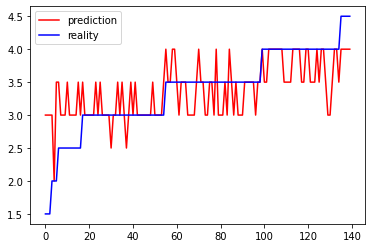

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

regr = RandomForestRegressor(max_depth=4, n_estimators=10, random_state=42)
regr.fit(X_train, y_train)

y_pred = []
for _ in regr.predict(X_test):
    y_pred.append(_)

y_true = []
for _ in y_test:
    y_true.append(_)

y_dict = {}
for x in range(0, len(y_true)):
    y_dict[x] = y_true[x]

y_dict = sorted(y_dict.items(), key=lambda x:x[1])
y_dict = dict(y_dict)

new_dict = []
for x in y_dict:
    new_dict.append(y_pred[x])

y_pred = new_dict.copy()
y_true = []
for x in y_dict.values():
    y_true.append(x)

for pred in range(0, len(y_pred)):
    y_pred[pred] = round(y_pred[pred] * 2) / 2

# print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
# print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
# print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
# print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
# print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
# print('Max Error:', metrics.max_error(y_true, y_pred))
# print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
# print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
# print('R^2:', metrics.r2_score(y_true, y_pred))
# print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
# print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

with PdfPages(r'C:\Users\Collin\Downloads\RFR.pdf') as export_pdf:
    plt.plot(y_pred, color='red', label='prediction')
    plt.plot(y_true, color='blue', label='reality')
    plt.legend()
    export_pdf.savefig()
    plt.show()
    plt.close()

In [123]:
import pickle

random_forest_regressor_filename = 'random_forest_regressor_20210623.pkl'
random_forest_regressor_pkl = open(random_forest_regressor_filename, 'wb')
pickle.dump(regr, random_forest_regressor_pkl)
random_forest_regressor_pkl.close()

In [125]:
random_forest_regressor_pkl = open(random_forest_regressor_filename, 'rb')
random_forest_regressor = pickle.load(random_forest_regressor_pkl)
print('loaded model :: ', random_forest_regressor)

loaded model ::  RandomForestRegressor(max_depth=4, n_estimators=10, random_state=42)


In [129]:
random_forest_regressor.predict([X_test.iloc[0]])

array([3.43065981])

In [152]:
import pickle
random_forest_regressor_filename = 'random_forest_regressor_20210623.pkl'
random_forest_regressor_pkl = open(random_forest_regressor_filename, 'rb')
random_forest_regressor = pickle.load(random_forest_regressor_pkl)
collin = [pd.Series(
    {'Year': 2010.0,
    'IMDb': 70.0,
    'Rotten Tomatoes': 65.0,
    'Metacritic': 56.0,
    'BoxOffice': 117229696.0,
    'Runtime': 94.0,
    'Action': 0.0,
    'Adventure': 0.0,
    'Animation': 0.0,
    'Biography': 0.0,
    'Comedy': 0.0,
    'Crime': 0.0,
    'Documentary': 1.0,
    'Drama': 0.0,
    'Family': 0.0,
    'Horror': 0.0,
    'Mystery': 0.0,
    'Romance': 0.0,
    'no_genre': 0.0,
    'Approved': 0.0,
    'G': 0.0,
    'N/A': 0.0,
    'PG': 0.0,
    'PG-13': 0.0,
    'R': 1.0,
    'TV-14': 0.0,
    'TV-G': 0.0,
    'TV-MA': 0.0,
    'TV-PG': 0.0,
    'Unrated': 0.0}
)]
prediction = random_forest_regressor.predict(collin)
print(prediction)

array([3.43065981])

# XGBoost for Regression

Mean Absolute Error (MAE): 0.375
Mean Squared Error (MSE): 0.2625
Root Mean Squared Error (RMSE): 0.51234753829798
Mean Absolute Percentage Error (MAPE): 0.12450113378684807
Explained Variance Score: 0.3097044937926212
Max Error: 1.5
Mean Squared Log Error: 0.016706229193176863
Median Absolute Error: 0.5
R^2: 0.2802937576499388
Mean Poisson Deviance: 0.0867306348195001
Mean Gamma Deviance: 0.029717228968553253


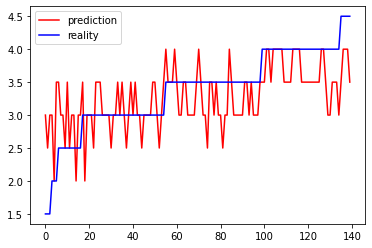

In [4]:
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

xg = xgb.XGBRegressor(n_estimators=10, max_depth=5, random_state=42)
xg.fit(X_train, y_train)

y_pred = []
for _ in xg.predict(X_test):
    y_pred.append(_)

y_true = []
for _ in y_test:
    y_true.append(_)

y_dict = {}
for x in range(0, len(y_true)):
    y_dict[x] = y_true[x]

y_dict = sorted(y_dict.items(), key=lambda x:x[1])
y_dict = dict(y_dict)

new_dict = []
for x in y_dict:
    new_dict.append(y_pred[x])

y_pred = new_dict.copy()
y_true = []
for x in y_dict.values():
    y_true.append(x)

for pred in range(0, len(y_pred)):
    y_pred[pred] = round(y_pred[pred] * 2) / 2

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

with PdfPages(r'C:\Users\Collin\Downloads\XGB.pdf') as export_pdf:
    # plt.scatter(np.arange(len(y_pred)), y_pred, color='blue', label='prediction')
    # plt.scatter(np.arange(len(y_pred)), y_true, color='red', label='reality')
    plt.plot(y_pred, color='red', label='prediction')
    plt.plot(y_true, color='blue', label='reality')
    plt.legend()
    export_pdf.savefig()
    plt.show()
    plt.close()

# Linear Regression

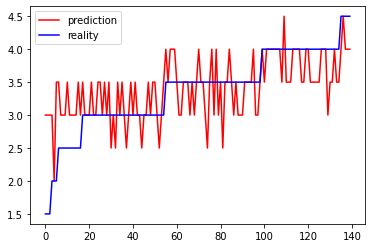

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = []
for _ in linreg.predict(X_test):
    y_pred.append(_)

y_true = []
for _ in y_test:
    y_true.append(_)

y_dict = {}
for x in range(0, len(y_true)):
    y_dict[x] = y_true[x]

y_dict = sorted(y_dict.items(), key=lambda x:x[1])
y_dict = dict(y_dict)

new_dict = []
for x in y_dict:
    new_dict.append(y_pred[x])

y_pred = new_dict.copy()
y_true = []
for x in y_dict.values():
    y_true.append(x)

for pred in range(0, len(y_pred)):
    y_pred[pred] = round(y_pred[pred] * 2) / 2

# print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
# print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
# print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
# print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
# print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
# print('Max Error:', metrics.max_error(y_true, y_pred))
# print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
# print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
# print('R^2:', metrics.r2_score(y_true, y_pred))
# print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
# print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

with PdfPages(r'C:\Users\Collin\Downloads\LINREG.pdf') as export_pdf:
    # plt.scatter(np.arange(len(y_pred)), y_pred, color='blue', label='prediction')
    # plt.scatter(np.arange(len(y_pred)), y_true, color='red', label='reality')
    plt.plot(y_pred, color='red', label='prediction')
    plt.plot(y_true, color='blue', label='reality')
    plt.legend()
    export_pdf.savefig()
    plt.show()
    plt.close()

# Ridge Regression

C:\Users\Collin\.virtualenvs\fucking_with_film-31rp7xRM\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.04103e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


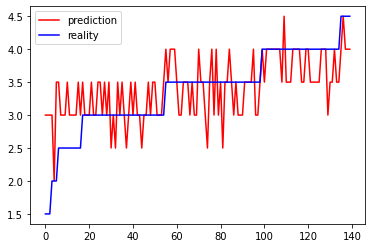

In [6]:
from sklearn.linear_model import Ridge
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

rreg = Ridge(alpha=1)
rreg.fit(X_train, y_train)

y_pred = []
for _ in rreg.predict(X_test):
    y_pred.append(_)

y_true = []
for _ in y_test:
    y_true.append(_)

y_dict = {}
for x in range(0, len(y_true)):
    y_dict[x] = y_true[x]

y_dict = sorted(y_dict.items(), key=lambda x:x[1])
y_dict = dict(y_dict)

new_dict = []
for x in y_dict:
    new_dict.append(y_pred[x])

y_pred = new_dict.copy()
y_true = []
for x in y_dict.values():
    y_true.append(x)

for pred in range(0, len(y_pred)):
    y_pred[pred] = round(y_pred[pred] * 2) / 2

# print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
# print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
# print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
# print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
# print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
# print('Max Error:', metrics.max_error(y_true, y_pred))
# print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
# print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
# print('R^2:', metrics.r2_score(y_true, y_pred))
# print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
# print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

with PdfPages(r'C:\Users\Collin\Downloads\RREG.pdf') as export_pdf:
    # plt.scatter(np.arange(len(y_pred)), y_pred, color='blue', label='prediction')
    # plt.scatter(np.arange(len(y_pred)), y_true, color='red', label='reality')
    plt.plot(y_pred, color='red', label='prediction')
    plt.plot(y_true, color='blue', label='reality')
    plt.legend()
    export_pdf.savefig()
    plt.show()
    plt.close()

# Neural Networks?

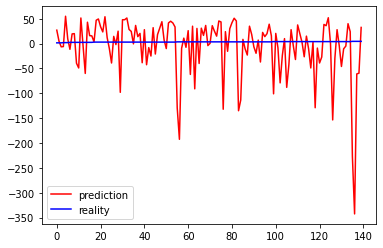

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

MLPREG = MLPRegressor()
MLPREG.fit(X_train, y_train)

y_pred = []
for _ in MLPREG.predict(X_test):
    y_pred.append(_)

y_true = []
for _ in y_test:
    y_true.append(_)

y_dict = {}
for x in range(0, len(y_true)):
    y_dict[x] = y_true[x]

y_dict = sorted(y_dict.items(), key=lambda x:x[1])
y_dict = dict(y_dict)

new_dict = []
for x in y_dict:
    new_dict.append(y_pred[x])

y_pred = new_dict.copy()
y_true = []
for x in y_dict.values():
    y_true.append(x)

for pred in range(0, len(y_pred)):
    y_pred[pred] = round(y_pred[pred] * 2) / 2

# print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
# print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
# print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
# print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
# print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
# print('Max Error:', metrics.max_error(y_true, y_pred))
# print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
# print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
# print('R^2:', metrics.r2_score(y_true, y_pred))
# print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
# print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

with PdfPages(r'C:\Users\Collin\Downloads\MLPREG.pdf') as export_pdf:
    # plt.scatter(np.arange(len(y_pred)), y_pred, color='blue', label='prediction')
    # plt.scatter(np.arange(len(y_pred)), y_true, color='red', label='reality')
    plt.plot(y_pred, color='red', label='prediction')
    plt.plot(y_true, color='blue', label='reality')
    plt.legend()
    export_pdf.savefig()
    plt.show()
    plt.close()